

# Diabetic Retinopathy - Detecting Blindness

### APTOS 2019 Blindness

Diabetic Retinopathy is a diabetic realted disease that affects the retina of the eye. Millions around the world suffer from this disease.

Currently, diagnosis happens through the use of a technique called fundus photography, which involves photographing the rear of the eye.

Medical screening for diabetic retinopathy occurs around the world, but is more difficult for people living in rural areas. 

Using machine learning and computer vision, we attempt to automate the process of diagnosis, which currently is manually being performed doctors. 

On Kaggle (https://www.kaggle.com/c/aptos2019-blindness-detection/data and https://www.kaggle.com/c/diabetic-retinopathy-detection) we will have access to a dataset of tens of thousands of real-world clinical images of both healthy patients and pateints with the disease, and labelled by trained clinicians.

Using this dataset, we'll be able to train a machine learning model to acheive a high level of accuracy when predicting occurrences of the disease in patients.


## Results

We train our model on a combined dataset of approx 40,000 images. We then perform inference against the public and private leaderboard on Kaggle for the APTOS 2019 competition. The public leaderboard contains approx 30% of the total test dataset, and the private LB 70%. The test set contains in total approx 13,000 images at over 20gb in size.

The models are trained offline, and then uploaded to a Kaggle private data set linked to the kernel, which we use soley for inference. 

We also make sure to pre-process the test images with the same image treatments that were performed on the training data. We use a custom ItemList to perform image manipulations on the test set before running our predictions.

Using an ensemble of B3 and B5 Efficientnets, we achieve a Quadratic Weighted Kappa score of **0.905775**. 

In comparison, the winning solution achieved **0.936129**



## Contents

The following notebook has been organised as follows:

1. Code has been listed initially first, and roughly sectioned off into the following key parts. It is worth going through this code, and as you read through the next major section of experiment discusssion, you can refer back to the code section as is relevant.
    - Imports and Setup
    - Image processing
    - Metrics
    - Learner and Databunch
    - Predictions and Inference
    - Pipeline experimental methods
2. Outline of experiment and results
    - Data exploration
    - Image processing baselines
    - Model and architecture baselines. Decide if Regression or Classification is the best approach.
    - Adding data and data augmentations
    - Increasing image size
    - Tuning other hyperparameters like dropout and weight decay
    - Progressive resizing
    - Increasing epochs and training times
    - Ensembling
3. Appendix
    - Image pre-processing methods
    - Select experiments
    - References


---------

# Imports and Setup

The following cell contains all of the setup code for each of intialisation whenever restarting the kernel

In [30]:
from fastai.callbacks import*
from fastai.vision import *
from fastai.metrics import error_rate

# Import Libraries here
import os
import json 
import shutil
import zipfile
import numpy as np
import pandas as pd
import PIL
import cv2

from PIL import ImageEnhance

import scipy as sp
from functools import partial
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF

from torchvision.models import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pretrainedmodels
%load_ext jupyternotify
    

# set the random seed
np.random.seed(42)
    
    
import fastai; fastai.__version__

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


'1.0.57'

# Datasource Selectors

In my experiments I've setup a few data sources, both with the 2019 dataset only and also the combines 2019+2015 datasets. The code below helps me switch out between the two so I can benchmark with various options

In [31]:
# Downloaded from https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images

def switch2019Only(sub_folder:str = ''):
    base_dir = '/hdd/data/blindness-detection/2015_and_2019/'

    !mkdir -p "{base_dir}"

    train_img_path = f'{base_dir}train/{sub_folder}'  # need to split this folder into train and val sets
    test_img_path = f'{base_dir}test/{sub_folder}' # images only, use to test

    df_train = pd.read_csv(base_dir + 'labels/trainLabels19.csv')
    df_train.head()
    
    return (train_img_path, base_dir, train_img_path, test_img_path, df_train)

In [32]:
# Downloaded from https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images

def switch2015Only(sub_folder:str = ''):
    base_dir = '/hdd/data/blindness-detection/2015_and_2019/'

    !mkdir -p "{base_dir}"

    train_img_path = f'{base_dir}train/{sub_folder}'  # need to split this folder into train and val sets
    test_img_path = f'{base_dir}test/{sub_folder}' # images only, use to test

    df_train = pd.read_csv(base_dir + 'labels/trainLabels15.csv')
    df_train.columns = ['id_code', 'diagnosis']
    df_train.head()

    
    return (train_img_path, base_dir, train_img_path, test_img_path, df_train)

In [33]:
# Downloaded from https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images

def switch2019And2015(sub_folder:str = ''):
    base_dir = '/hdd/data/blindness-detection/2015_and_2019/'

    !mkdir -p "{base_dir}"

    train_img_path = f'{base_dir}train/{sub_folder}'  # need to split this folder into train and val sets
    test_img_path = f'{base_dir}test/{sub_folder}' # images only, use to test

    df_train_15 = pd.read_csv(base_dir + 'labels/trainLabels15.csv')
    df_train_15.columns = ['id_code', 'diagnosis']
    df_train_15.head()

    df_train_19 = pd.read_csv(base_dir + 'labels/trainLabels19.csv')
    df_train_19.head()

    df_train = pd.concat([df_train_15, df_train_19])
    df_train=df_train.reset_index(drop=True)
    df_train.head()

    
    return (train_img_path, base_dir, train_img_path, test_img_path, df_train)

    

# Metrics

In [34]:
# ---------- Metrics ----------

# Competition uses the quadric kappa metric, defined here
# Definition of Quadratic Kappa
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')
    

# Learner and Data

In [68]:
from torch.utils.data.sampler import WeightedRandomSampler

class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner,weights:torch.Tensor=None):
        super().__init__(learn)
        self.labels = self.learn.data.train_dl.dataset.y.items
        _, counts = np.unique(self.labels,return_counts=True)
        self.weights = (weights if weights is not None else
                        torch.DoubleTensor((1/counts)[self.labels.astype(int)]))
        self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data for i in range(len(self.learn.data.train_dl.dataset))])
        self.total_len_oversample = int(self.learn.data.c*np.max(self.label_counts))
    def on_train_begin(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(self.weights,self.total_len_oversample), self.learn.data.train_dl.batch_size,False)
    

    
# ---------- Learner and Databunch ----------
def get_data_bunch_explore(data_source, image_size, bs=64, mode=0, use_xtra_tfms=False):
    # data source
    data_in_use, base_dir, train_img_path, test_img_path, df_train = data_source
    print(f'Using data in: {train_img_path}') # print out which dataset is in use
    
    # lets start off with a small image size first 
    # and use progressive resizing to see how our initial model is performing
    sz=image_size 
    
    # 1. Setup data bunch
    source = (CleanedImageList
                .from_df(df_train, train_img_path, suffix='.jpg', image_size=sz, mode=mode)
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols='diagnosis',label_cls=FloatList))
    
    data_bunch = (
        source
            .databunch(bs=bs)
            .normalize(imagenet_stats)
        );
    
    # if using data aug
    if use_xtra_tfms:
        source = (CleanedImageList
                .from_df(df_train, train_img_path, suffix='.jpg', image_size=sz, mode=mode)
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols='diagnosis',label_cls=FloatList))
        
        transforms = get_transforms(do_flip=True, 
                              flip_vert=True,
                              max_rotate=360,
                              max_zoom=False, 
                              max_lighting=0.1,
                              p_lighting=0.5,
                              xtra_tfms=zoom_crop(scale=(1.01, 1.45), do_rand=True))
    
        data_bunch = (
            source
                .transform(transforms,size=sz)
                .databunch(bs=bs)
                .normalize(imagenet_stats)
            );
        
    
    return data_bunch
    
def get_data_bunch(data_source, image_size, bs=64, use_xtra_tfms=False):
    
    # data source
    data_in_use, base_dir, train_img_path, test_img_path, df_train = data_source
    print(f'Using data in: {train_img_path}') # print out which dataset is in use
    
    # lets start off with a small image size first 
    # and use progressive resizing to see how our initial model is performing
    sz=image_size 
    
    # 1. Setup data bunch
    source = (ImageList
                .from_df(df_train, train_img_path, suffix='.jpg')
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols='diagnosis',label_cls=FloatList))
        
    data_bunch = (
        source
            .databunch(bs=bs)
            .normalize(imagenet_stats)
        );
    
    if use_xtra_tfms:
        source = (ImageList
                .from_df(df_train, train_img_path, suffix='.jpg')
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols='diagnosis',label_cls=FloatList))

        transforms = get_transforms(do_flip=True, 
                                  flip_vert=True,
                                  max_rotate=360,
                                  max_zoom=False, 
                                  max_lighting=0.1,
                                  p_lighting=0.5,
                                  xtra_tfms=zoom_crop(scale=(1.01, 1.45), do_rand=True))


        data_bunch = (
            source
                .transform(transforms,size=sz)
                .databunch(bs=bs)
                .normalize(imagenet_stats)
            );
        
    
    # add test set
    sample_df = pd.read_csv(base_dir + 'sample_submission.csv')
    sample_df.head()
    
    # Remember, for inference, we should apply the same image processing as what we trained on!
    data_bunch.add_test(ImageList.from_df(sample_df,base_dir,folder='test',suffix='.jpg'))

    return data_bunch

# "pretrained" is hardcoded to adapt to the PyTorch model function
from efficientnet_pytorch import EfficientNet
def efficient_net(b_class='b5'):
    return EfficientNet.from_pretrained(f'efficientnet-{b_class}', num_classes=1)


def get_cnn_learner(arch, data_bunch, tofp16=True, oversample=False):
    
    # 1. Get data bunch
    data_bunch_cleaned = data_bunch
    
    callback_fns = [ShowGraph]
    
    if oversample:
        print('is oversampling')
        callback_fns = [partial(OverSamplingCallback), ShowGraph]     

    # 2. Setup new learner. 
    learner = Learner(data_bunch_cleaned, arch, model_dir="models", metrics=quadratic_kappa, callback_fns=callback_fns)
    
    if tofp16:
        learner = Learner(data_bunch_cleaned, arch, model_dir="models", metrics=quadratic_kappa, callback_fns=callback_fns)
        learner.to_fp16()

    return learner

## Pipelining Helper methods

I use these general helper methods to run training. These methods help encapsulate a lot of the benchmarking and training runs that I execute, and help to pass hyperparameters through easily whilst abstracting out some of the cnn setup code.

In [36]:
class Experiment():
    
    def __init__(self, name, data_source, arch, image_size, bs, wd, use_xtra_tfms, oversample, pretrained_model_name=None):
        
        super().__init__()
        
        self.name = name
        self.data_source = data_source
        self.arch = arch
        self.image_size = image_size
        self.bs = bs
        self.wd = wd
        self.use_xtra_tfms = use_xtra_tfms
        self.oversample = oversample
        self.pretrained_model_name = pretrained_model_name
        
        self.data_in_use, self.base_dir, self.train_img_path, self.test_img_path, self.df_train = self.data_source
        
        if self.pretrained_model_name:
            
            self.learner, self.data_bunch = get_learner_and_databunch(
                                                self.arch, 
                                                self.data_source,
                                                image_size=self.image_size,
                                                bs=self.bs,
                                                use_xtra_tfms=self.use_xtra_tfms,
                                                oversample=self.oversample)
            
            print(f'Loading pretrained model: {self.pretrained_model_name}')
            self.learner.load(self.base_dir + self.pretrained_model_name)
            self.learner.to_fp16()
            
        else:
            
            self.learner, self.data_bunch = get_learner_and_databunch(
                                                self.arch, 
                                                self.data_source,
                                                image_size=self.image_size,
                                                bs=self.bs,
                                                use_xtra_tfms=self.use_xtra_tfms,
                                                oversample=self.oversample)
            
    def find_lr(self):
        # find the inital lr for frozen training
        self.learner.lr_find(wd=self.wd)
        self.learner.recorder.plot(suggestion=True)
        
        
    def fit_frozen(self, epochs, lr):
        
        self.learner.fit_one_cycle(
            epochs, 
            lr, 
            wd=self.wd, 
            callbacks=[SaveModelCallback(self.learner, monitor='valid_loss', name=f'best_{self.name}')])
        
        %notify -m "fit_one_cycle finished"
        
        print(f'Saved model: {self.base_dir + self.name}')
        self.learner.save(self.base_dir + self.name)
        
    def unfreeze(self):
        self.learner.unfreeze()
        self.learner.lr_find()
        self.learner.recorder.plot()
        
    def fit_unfrozen(self, epochs, lr):
        
        self.learner.fit_one_cycle(
            epochs, 
            lr, 
            wd=self.wd, 
            callbacks=[SaveModelCallback(exp.learner, monitor='valid_loss', name=f'best_unf_{exp.name}')])
        
        %notify -m "unfrozen fit_one_cycle finished"


        self.learner.save(self.base_dir + 'unf_' + self.name)
        print(f'Saved model: {self.base_dir + "unf_" + self.name}')
        
    def load_frozen(self):
        self.learner.load(self.base_dir + self.name)
        self.learner.to_fp16()
              
    def load_best_frozen(self):
        self.learner.load(self.train_img_path + 'models/best_' + self.name)
        self.learner.to_fp16()
        print(f'Loaded best model {self.train_img_path + "models/best_" + self.name}')
        
    
        
    def get_kappa_score(self):
        get_kappa_score(self.learner)
        
    def show_batch(self):
        self.data_bunch.show_batch(4, figsize=(20,20))

# This method is a helper method that we use to help us setup a learner and a databunch with baselined defaults
# It returns the learner, the data bunch, and also runs an lr finder to use to find an appropriate learning rate to feed into fit one cycle
# The only required parameter is the architecture. For everything else 
# you can pass in overrides values to test different hyperparameters
def get_learner_and_databunch(
        arch, 
        data_source,
        image_size=128,
        bs=64,
        use_xtra_tfms=False,
        oversample=False):

    # data bunch
    data_bunch = get_data_bunch(
        data_source,
        image_size, 
        bs=bs, 
        use_xtra_tfms=use_xtra_tfms)

    # create a learner
    learner = get_cnn_learner(arch, data_bunch, oversample=oversample) 
    
        
    return (learner, data_bunch)


def get_kappa_score(learner):
    preds, y = learner.get_preds()
    score = quadratic_kappa(preds, y)
    print('Kappa score is {0}'.format(score))

    return score

---


# Summary

The following is an outline of how I approached the problem and is roughly in the order of how I tackled the project. At each stage the aim was to find the best settings that would allow me to move forward on each experiments, and I spent a lot of time getting to know the data, baselining, and trying to uncover bugs during the training process.

Roughly, the order of operations for this project are outlined below:

1. Exploratory Data analysis
2. Image processing baselines
3. Model and architecture baselines. Regression or Classification is the best approach.
4. Adding data and data augmentations
5. Increasing image size
7. Tuning other hyperparameters like dropout and weight decay
8. Progressive resizing
9. Increasing epochs and training times
10. Ensembling

### Common training settings

- Using transfer learning with pre-trained weights
- We use fit_one_cycle policy to help vary learning rates for best results.
- We use Adam as our optimiser
- Treated as a regression problem with MSELoss as our cost function.
- Oversampled the dataset
- Using expanded dataset from 2015 and 2019
- Using heavy data augmentations: flipping, rotation, zoom, crops, and lighting.

### Things we did not attempt

- Stratified Kfolds
- Test Time Augmentations
- Psuedo labelling





# Exploratory Data Analysis (EDA)

Before we start any training we try to get a good sense of the raw data, understand its distributions, and explore its features and idiosyncracies.

Getting to know our dataset is an important first step, and helps us tune our model towards more accurate predictions.

Loaded pretrained weights for efficientnet-b2
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/


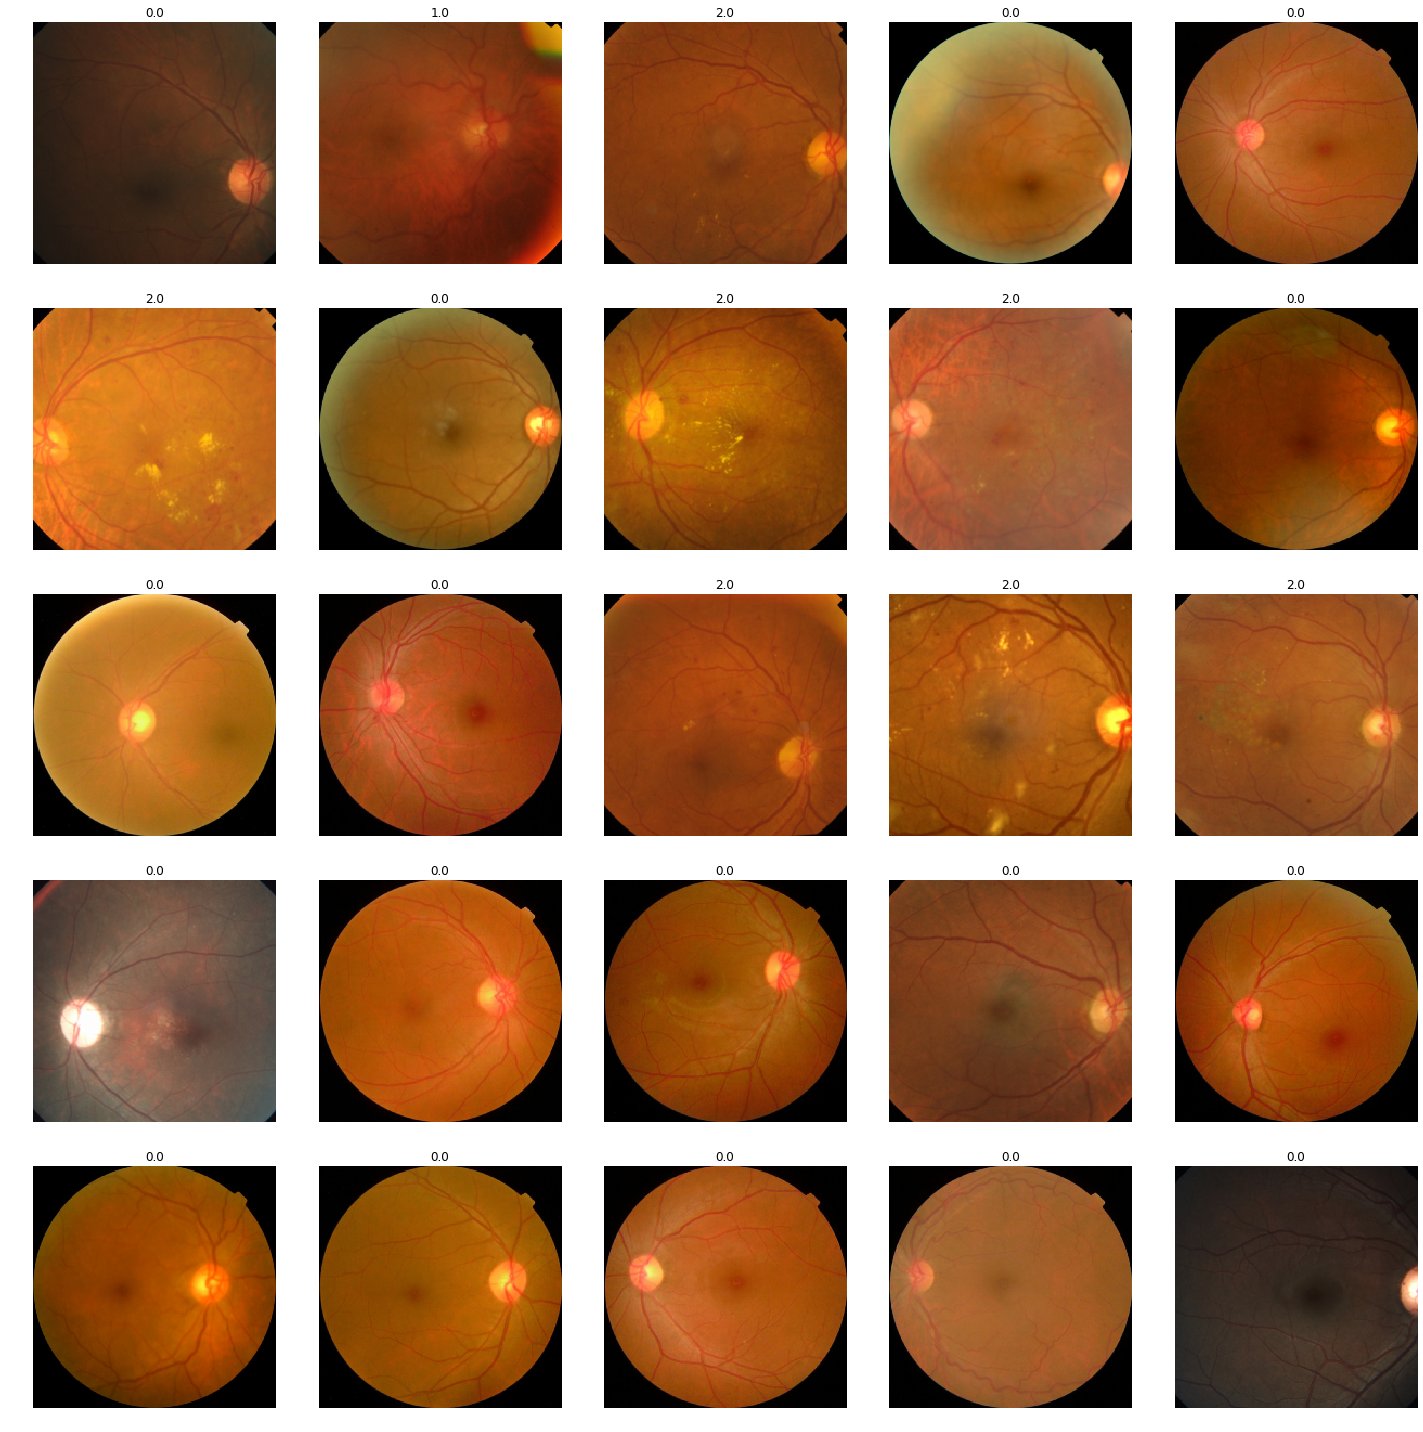

In [19]:
data_source = switch2019Only()

learner, data_bunch = get_learner_and_databunch(
        efficient_net('b2'), 
        data_source,
        image_size=224,
        bs=32,
        use_xtra_tfms=False,
        oversample=False)

data_bunch.show_batch(5, figsize=(20,20))

### Inconsistent cropping and lighting

As we can see from the above images, the input images are inconsistently cropped, and is the product of coming from a variety of different sources, equipment quality, and time periods. 

Another inconsistency is the lighting used in theses images. 

We need to help improve the consistency of the images so that it helps the model work more effectvely. A start would be to get the cropping and lighting consistent across all of the images.

Let's see what happens when we do some image processing:


### Data imbalance

We can see here that there is a definite data imbalance with the supplied data. A large percentage of the images coming through are actually normal, rather than containing any diabetic retinopathy.

We deal with this imbalance by oversampling the less dominant classes.

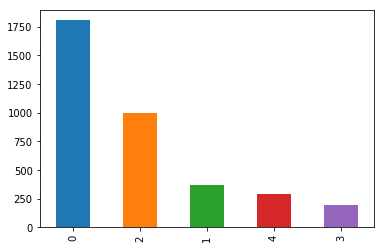

In [20]:
# checking for data imbalances
data_in_use, base_dir, train_img_path, test_img_path, df_train = data_source
counts = df_train.diagnosis.value_counts() 
counts.plot(kind='bar')

---

# Data Processing

To deal with the above problems, we tried to implement the following solutions to improve the input into the network.

## Pre-resize

We first pre-resize our images into the sizes we want to give to our model. This gives us a signficant boost in trainign speed over resizing the images on the fly (say through a custom ItemList) 

We create subfolders with resized versions of the images so we can retain the original images. When we resize the images, we also apply the various colour, cropping and image processing treatments so that we also do not have to perform them on the fly.

## Image Preprocessing

Below I've explored various image processing strategies. The goal here was to normalise exposure, contrast and cropping as much as possile across the dataset to make it easier for our neural net to work on. 

Filtering out the green channel was explored, along with various Gaussian filters and also various cropping tasks.

In the end we found that a simple colour and circle crop provided the best results.

The different processing methods that were explored can be seen below. 

#### Circle crop and resize

The following image batch displays the image pre-processing that was eventually applied in our final training runs. These were a simple circle crop and resize, and standardising the black corners.

Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/


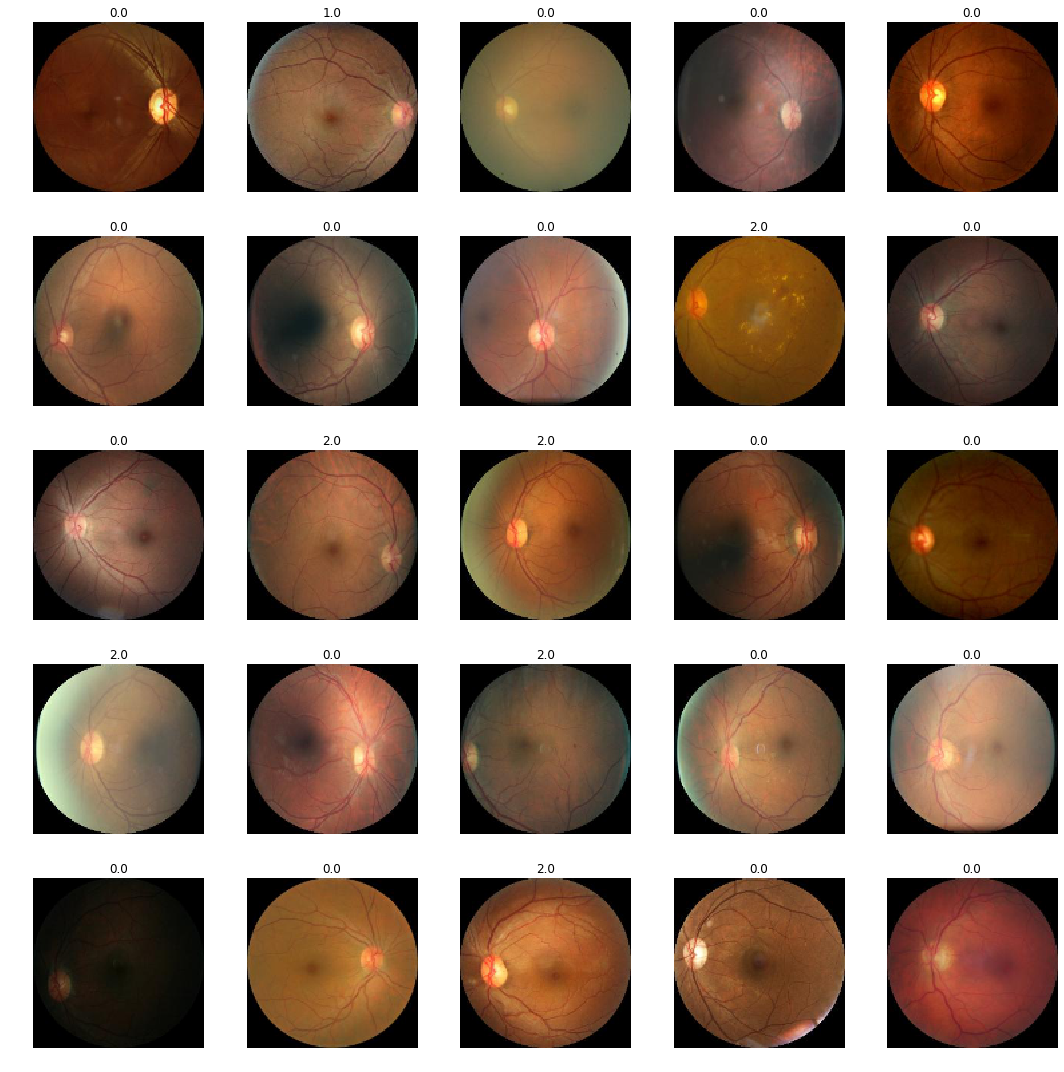

In [74]:
data_source = switch2019And2015(sub_folder = '224/')
data_bunch = get_data_bunch_explore(data_source, image_size=128, bs=64, mode=3)
data_bunch.show_batch(5, figsize=(15,15))

#### Colour Raw images circle cropped with CLAHE

Original raw image with Contrast Limited Adaptive Histogram Equalisation (CLAHE) with circle cropping.

Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/


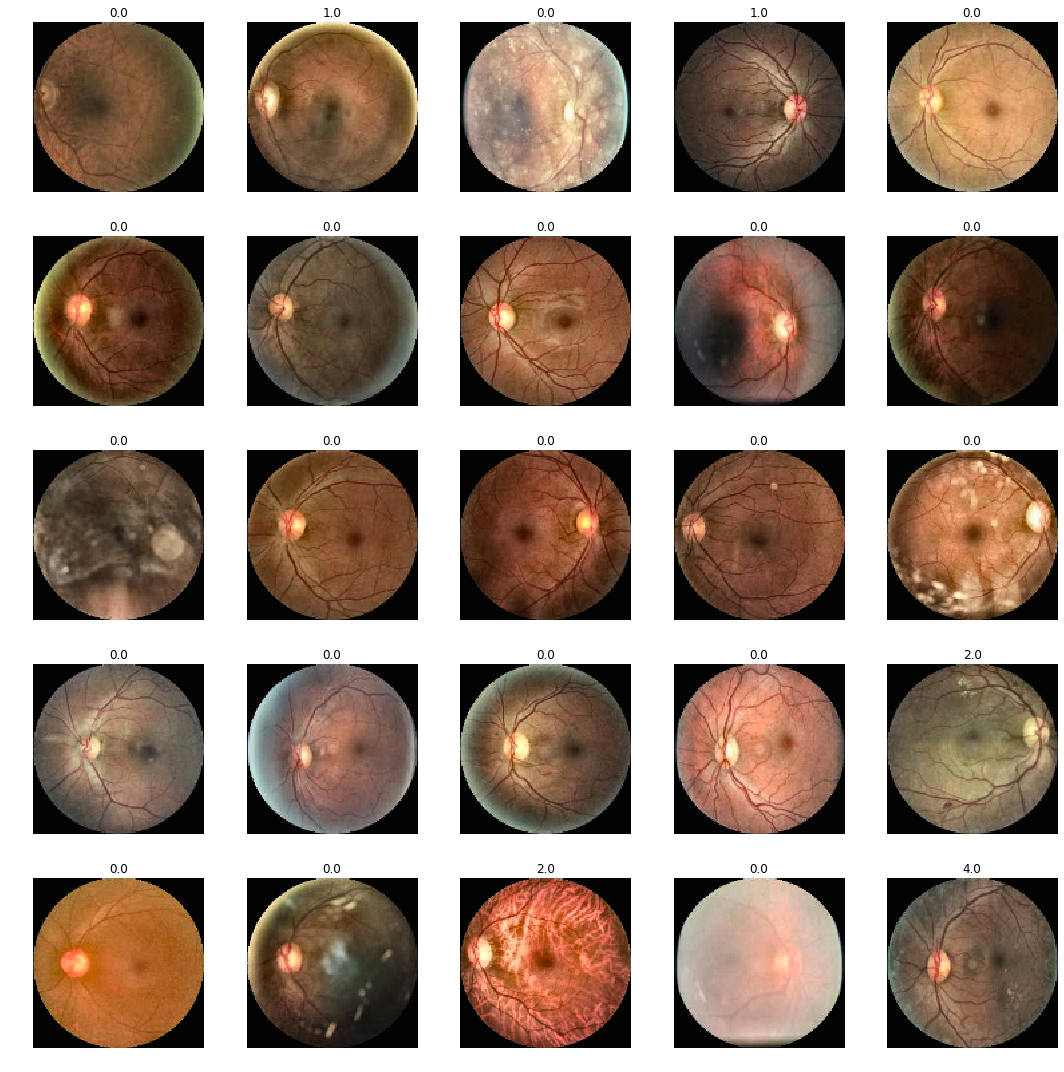

In [54]:
data_source = switch2019And2015(sub_folder = '224/')
data_bunch = get_data_bunch_explore(data_source, image_size=128, bs=64, mode=0)
data_bunch.show_batch(5, figsize=(15,15))

#### Green Channel Filter and Circle Crop

The paper here featured research around filtring out the green channel of the images to further highlight diabetic retinopathy indicators. http://biomedpharmajournal.org/vol10no2/diabetic-retinal-fundus-images-preprocessing-and-feature-extraction-for-early-detection-of-diabetic-retinopathy/

Although this provided good results, keeping the raw image colourisations seemed to work better in practice.

Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/


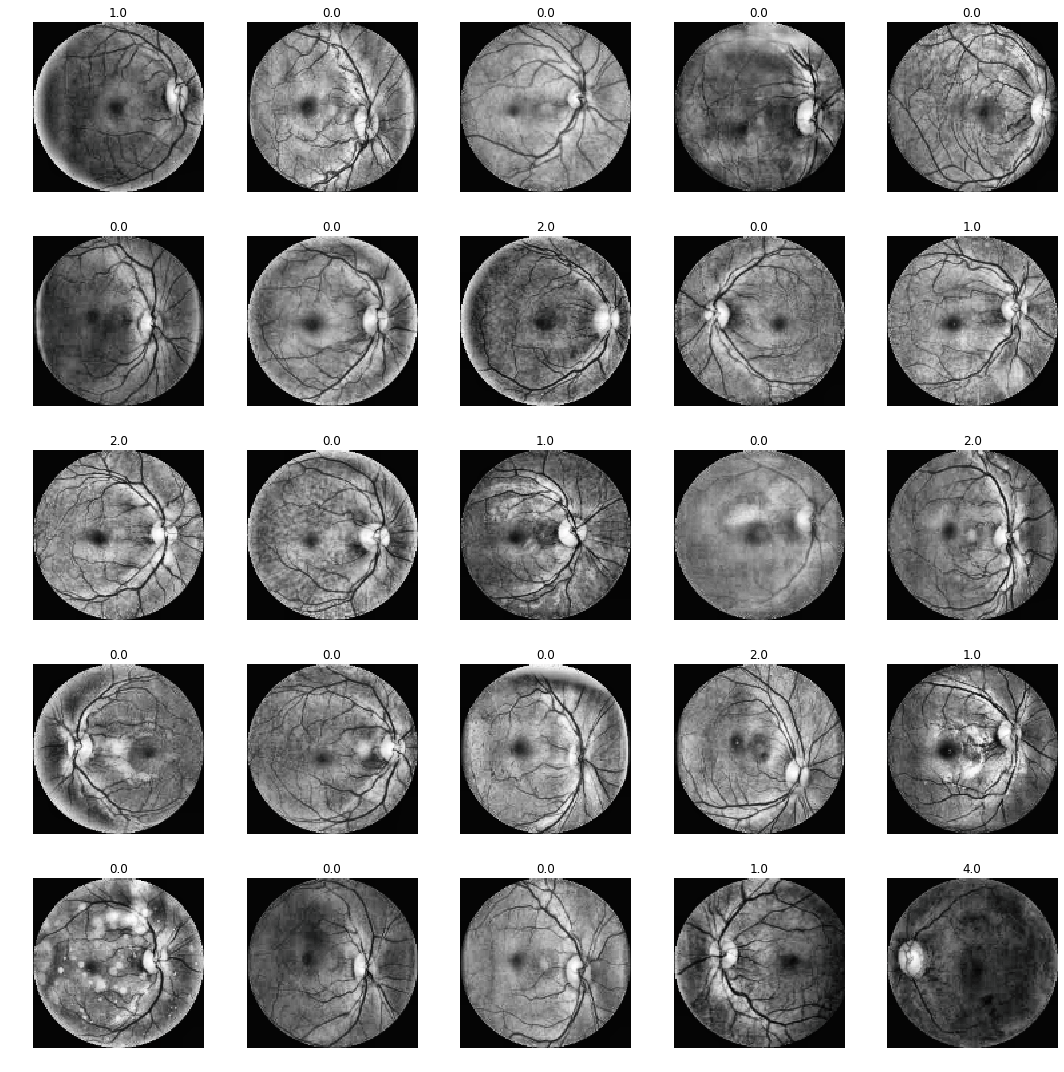

In [69]:
data_source = switch2019And2015(sub_folder = '224/')
data_bunch = get_data_bunch_explore(data_source, image_size=128, bs=64, mode=1)
data_bunch.show_batch(5, figsize=(15,15))

#### Gaussian Filters (Ben's processing methods)

I also experimented with some cropping and gaussian colorisation filters that were outlined in the following kernel: https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping

Compared to using the raw colour vs green channel filter, vs Gaussian filter methods, we observed during training that that Gaussian filters actually resulted is visibly poorer results in training.

Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/


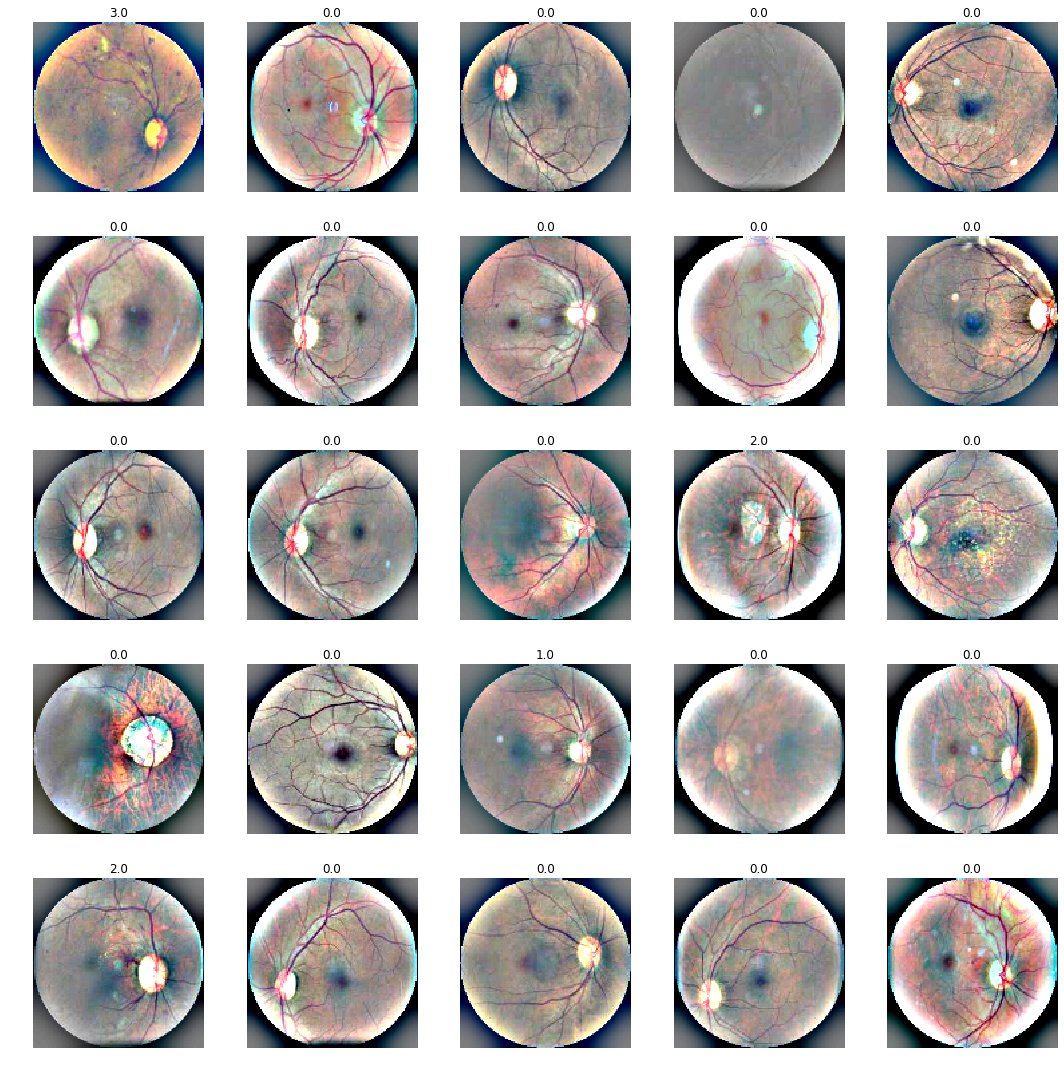

In [61]:
data_source = switch2019And2015(sub_folder = '224/')
data_bunch = get_data_bunch_explore(data_source, image_size=128, bs=64, mode=2)
data_bunch.show_batch(5, figsize=(15,15))



## Oversample

Our dataset displays a class imbalance, a situation where there is a disproportionate amount of images classified to one particular class. In this case, there are a lot of images of healthy eyes in the dataset.

In order to give our model enough examples to learn to detect instances of diabetic retinpathy, we can try a technique called oversampling.

By oversampling we are in essence creating duplicates of our data. This creates a scenario where our network could start to overfit. We need to observe this and balance this out with some regularisation.

Ref: https://forums.fast.ai/t/oversampling-callback/48997


#### Experimental results:

Even though the dataset was imbalanced, we found that oversampling introduced worse results.



---

# TRAINING

Here we start looking at setting up our learners for training. As mentioned previously, training is performed offline, and the resulting models are then uploaded to Kaggle datasets and the kernel for inference on the public and private test set.

A summary of the key hyperparameters and setups that worked are listed below:

1. Fit one cycle policy for discriminitive learning rates.
2. Combine 2015 and 2019 datasets
4. Heavy data augmentations with cropping, lighting, and rotation.
5. Progressive resizing
6. Using EfficientNets: We explored a number of options for architectures. Including Resnets and Densenets. We found that EfficientNets provided the best results, so we use this with pretrained weights as our baseline architecture. https://arxiv.org/abs/1905.11946
7. Chose to approach this problem as a classifciation problem rather than a regression problem.
8. Adam optimiser.
9. Ensembling multiple models.




## Classification or Regression

Try use CrossEntropyLoss and MSELoss (experiments not detailed below but I was able to determine previously that treating this as a regression problem gave best results).




## More Data

Instead of training just on the 2019 dataset, we could use transfer learning and train on the 2015 dataset, and then use this as a pretrained network to train the 2019 dataset. 

The other option was to combine both the 2015 and 2019 datasets into one large dataset. 

This strategy provided the best results and generalised better on the private LB.


## Data Augmentations

Data augmentations can be incredibly effective in improving machine learning models. Heavy augmentations seemed to help quite a lot in boosting accuracy in this competition.

In the original dataset we can see a lot of variability around lighting and cropping. We deal with this in one way through image pre-processing and standardising the original images. Another we deal with this is using data augmentation. 

Along with serving as a means of regularisation and effectively increasing our dataset size, we also augment the data with a series of cropping, rotation, lighting, and zooming augmentations in an effort to smooth out the effect of the inconsistencies present in the photography of the original dataset. 

The following displays the results of our augmentations.

Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/


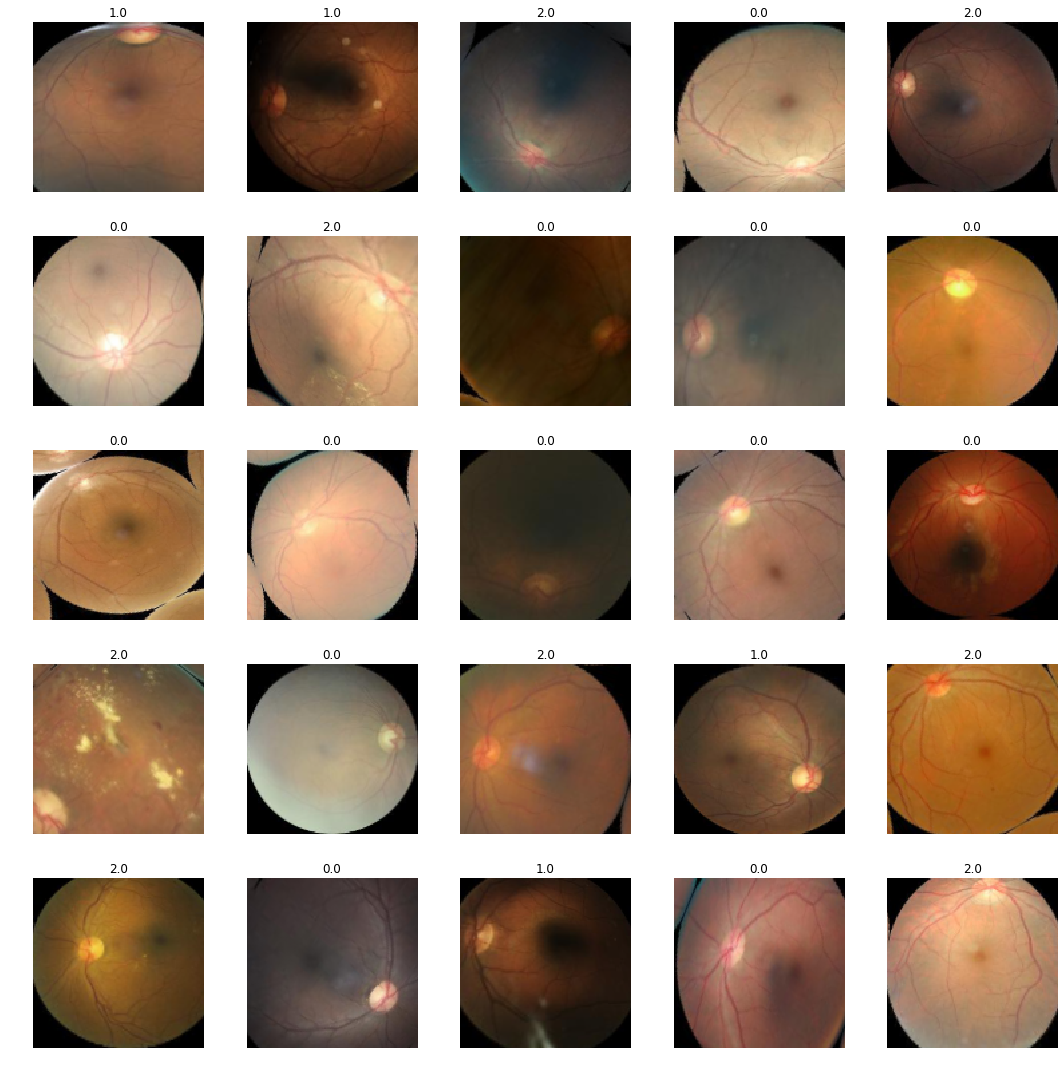

In [76]:
data_source = switch2019And2015(sub_folder = '224/')
data_bunch = get_data_bunch_explore(data_source, image_size=128, bs=64, mode=3, use_xtra_tfms=True)
data_bunch.show_batch(5, figsize=(15,15))

## Progressive Resizing

We get better results by starting with smaller images, and then gradually transfer learning to larger images. We start with a size of 224px for our training. Then feed the weights of these to the model trained against 352px images.

## EfficientNet (B3)

In [37]:
# Our baseline hyperparameters
def get_baseline_train_b3(name, data_source, bs, sz, pretrained_model_name=None):
    
    return Experiment(
            name=name, 
            data_source=data_source, 
            arch=efficient_net('b3'), 
            image_size=sz, 
            bs=bs, 
            wd=1e-2,
            use_xtra_tfms=True, 
            oversample=False, 
            pretrained_model_name=pretrained_model_name)

## (B3) 224px

#### Freeze

Loaded pretrained weights for efficientnet-b3
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


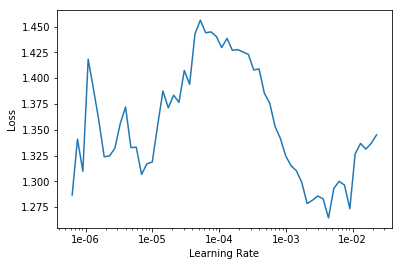

In [9]:
data_source = switch2019And2015(sub_folder = '224/')
exp = get_baseline_train_b3('exp_full_train_224_efficientnet-b3', data_source, bs=32, sz=224)
exp.find_lr()

In [10]:
exp.fit_frozen(50, 2e-3)

Better model found at epoch 35 with valid_loss value: 0.4752731919288635.
Better model found at epoch 38 with valid_loss value: 0.4523259401321411.
Better model found at epoch 40 with valid_loss value: 0.4514419138431549.
Better model found at epoch 41 with valid_loss value: 0.44921305775642395.
Better model found at epoch 43 with valid_loss value: 0.4359509348869324.


<IPython.core.display.Javascript object>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


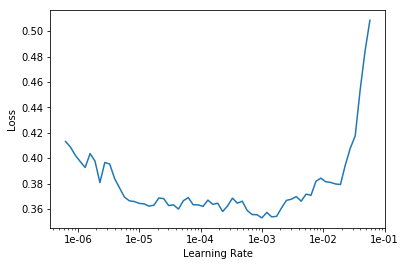

In [11]:
exp.unfreeze()

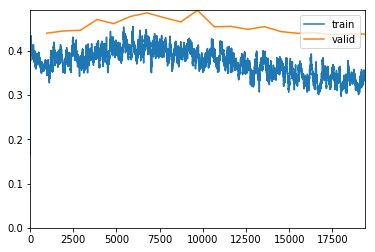

Better model found at epoch 0 with valid_loss value: 0.43965739011764526.
Better model found at epoch 15 with valid_loss value: 0.4392130374908447.
Better model found at epoch 17 with valid_loss value: 0.43600040674209595.


<IPython.core.display.Javascript object>

In [19]:
exp.fit_unfrozen(20, 2e-3/3)

## (B3) 352px. 
### Pretrained with 224px.

#### Freeze

Loaded pretrained weights for efficientnet-b3
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/352/
Using get_transforms
Loading pretrained model: unf_exp_full_train_224_efficientnet-b3


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


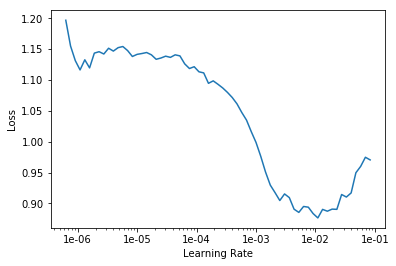

In [11]:
data_source = switch2019And2015(sub_folder = '352/')

exp = get_baseline_train_b3(
        'exp_full_train_352_efficientnet-b3', 
        data_source, 
        bs=16, 
        sz=352, 
        pretrained_model_name='unf_exp_full_train_224_efficientnet-b3')

exp.find_lr()

/home/adeperio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


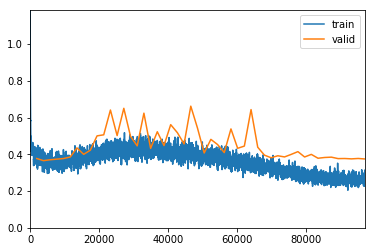

Better model found at epoch 0 with valid_loss value: 0.3769490420818329.
Better model found at epoch 1 with valid_loss value: 0.36530375480651855.


<IPython.core.display.Javascript object>

In [12]:
exp.fit_frozen(50, 1e-3)

In [11]:
data_source = switch2019And2015(sub_folder = '352/')

exp = get_baseline_train_b3(
        'exp_full_train_352_efficientnet-b3', 
        data_source, 
        bs=16, 
        sz=352)

exp.load_frozen()

Loaded pretrained weights for efficientnet-b3
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/352/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


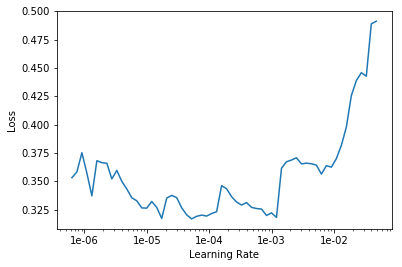

In [12]:
exp.unfreeze()

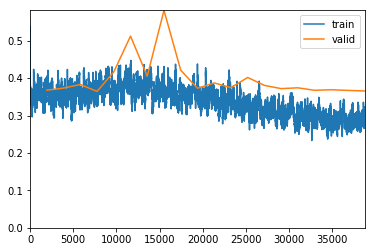

Better model found at epoch 0 with valid_loss value: 0.367678701877594.
Better model found at epoch 3 with valid_loss value: 0.3643893301486969.


/home/adeperio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


<IPython.core.display.Javascript object>

Saved model: /hdd/data/blindness-detection/2015_and_2019/unf_exp_full_train_352_efficientnet-b3


In [13]:
exp.fit_unfrozen(20, 5e-4)

## Efficientnet (B5)

In [13]:
# Our baseline hyperparameters
def get_baseline_train_b5(name, data_source, bs, sz, pretrained_model_name=None):
    
    return Experiment(
            name=name, 
            data_source=data_source, 
            arch=efficient_net('b5'), 
            image_size=sz, 
            bs=bs, 
            wd=1e-2,
            use_xtra_tfms=True, 
            oversample=False, 
            pretrained_model_name=pretrained_model_name)

## (B5) 224px

#### Freeze

Loaded pretrained weights for efficientnet-b5
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


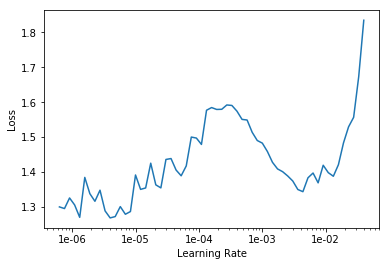

In [9]:
data_source = switch2019And2015(sub_folder = '224/')
exp = get_baseline_train_b5('exp_full_train_224_efficientnet-b5', data_source, bs=16, sz=224)
exp.find_lr()

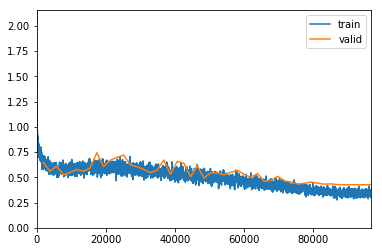

Better model found at epoch 0 with valid_loss value: 0.6462504267692566.
Better model found at epoch 1 with valid_loss value: 0.560756266117096.
Better model found at epoch 3 with valid_loss value: 0.524396538734436.


/home/adeperio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Better model found at epoch 33 with valid_loss value: 0.4585687518119812.
Better model found at epoch 37 with valid_loss value: 0.45334669947624207.
Better model found at epoch 38 with valid_loss value: 0.4347122013568878.
Better model found at epoch 42 with valid_loss value: 0.4318144917488098.
Better model found at epoch 44 with valid_loss value: 0.4268737733364105.
Better model found at epoch 45 with valid_loss value: 0.42627590894699097.
Better model found at epoch 47 with valid_loss value: 0.4262005686759949.


<IPython.core.display.Javascript object>

Saved model: /hdd/data/blindness-detection/2015_and_2019/exp_full_train_224_efficientnet-b5


In [10]:
exp.fit_frozen(50, 1e-3)

In [10]:
data_source = switch2019And2015(sub_folder = '224/')

exp = get_baseline_train_b5(
        'exp_full_train_224_efficientnet-b5', 
        data_source, 
        bs=16, 
        sz=224)

exp.load_frozen()

Loaded pretrained weights for efficientnet-b5
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


### Unfrozen

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


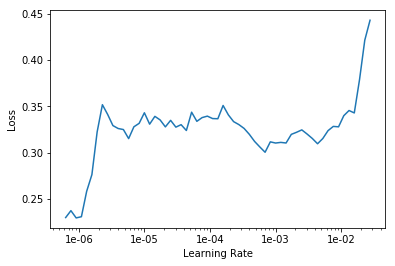

In [11]:
exp.unfreeze()

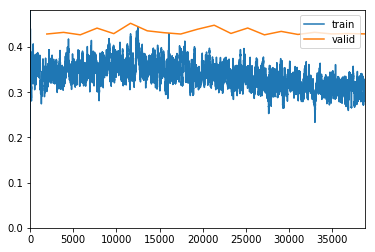

Better model found at epoch 0 with valid_loss value: 0.42880508303642273.
Better model found at epoch 2 with valid_loss value: 0.42704999446868896.


/home/adeperio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Better model found at epoch 13 with valid_loss value: 0.42697182297706604.


<IPython.core.display.Javascript object>

Saved model: /hdd/data/blindness-detection/2015_and_2019/unf_exp_full_train_224_efficientnet-b5


In [12]:
exp.fit_unfrozen(20, 1e-3/5)

## (B5) 352px. Pretrained witth 224px.

Loaded pretrained weights for efficientnet-b5
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/352/
Using get_transforms
Loading pretrained model: unf_exp_full_train_224_efficientnet-b5


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


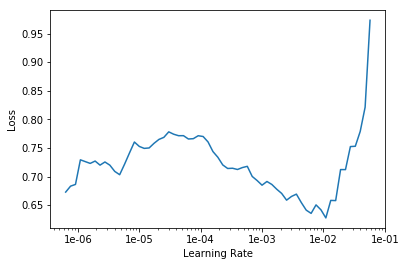

In [9]:
data_source = switch2019And2015(sub_folder = '352/')

exp = get_baseline_train_b5(
        'exp_full_train_352_efficientnet-b5', 
        data_source, 
        bs=8, 
        sz=352, 
        pretrained_model_name='unf_exp_full_train_224_efficientnet-b5')

exp.find_lr()

### (B5) Frozen 352 Training

/home/adeperio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


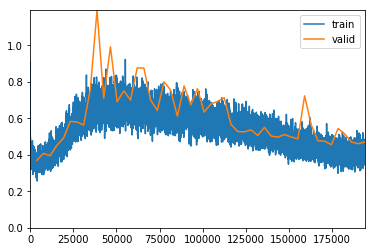

Better model found at epoch 0 with valid_loss value: 0.37010443210601807.


<IPython.core.display.Javascript object>

Saved model: /hdd/data/blindness-detection/2015_and_2019/exp_full_train_352_efficientnet-b5


In [10]:
exp.fit_frozen(50, 3e-3)

Loaded best model /hdd/data/blindness-detection/2015_and_2019/train/352/models/best_exp_full_train_352_efficientnet-b5


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


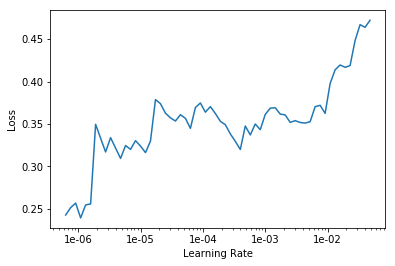

In [10]:
# loading the best frozen score and unfreezing
exp.load_best_frozen()
exp.unfreeze()

### (B5) Unfrozen 352 Training

/home/adeperio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


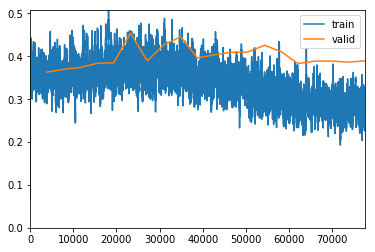

Better model found at epoch 0 with valid_loss value: 0.3629795014858246.


<IPython.core.display.Javascript object>

Saved model: /hdd/data/blindness-detection/2015_and_2019/unf_exp_full_train_352_efficientnet-b5


In [11]:
exp.fit_unfrozen(20, 3e-4)

# INFERENCE

Inference is performed directly in a Kaggle kernel after uploading the trained models to a Kaggle private dataset. 

Before we perform inference, the test set has not been pre-processed like the images in our training set. 

So here we use a custom Fastai ItemList (CleanedImageList) and apply the same image pre-processing the images in our test set (circle crop, resize). If we don't do this our predictions will be significantly off.

In [ ]:
class CleanedImageList(ImageList):
    
    def __init__(self, *args, image_size=224, **kwargs):
        super().__init__(*args, **kwargs)
        self.image_size = image_size
        self.copy_new.append('image_size')
        
    def open(self, dirName):

        image = cv2.imread(dirName)
        image = circle_crop_v2(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (int(self.image_size), int(self.image_size)))
        return Image(pil2tensor(image, np.float32).div_(255)) # fastai format

We then take the following models and ensemble them using simple averaging:

- EfficientNet B3 on 224px images.
- EfficientNet B3 progressive resized to 352px images.
- EfficientNet B5 on 224px images.
- EfficientNet B5 progressive resized to 352px images.

## Result

After inference, we get a result of **0.905775** on the private dataset (70% of the data)

---

# APPENDIX





# Data Source 

Our source of data is from the APTOS 2019 Blindness Detection competition on Kaggle. 

We end up actually amalgamating two data sources: one from a previous 2015 competitiona and the 2019 dataset. 

See the references section for the full suite of download routines used. It's been moved to the bottom of this notebook for document cleanliness.

In [ ]:
# Download the data
!pip install kaggle
!kaggle competitions download -c aptos2019-blindness-detection -p "{base_dir}"


# Image Processing

The original images of the data set were pre-process and resaved with cropping and resizing. The code to do that is included below.

In [65]:
# ---------- Cleaning Images ----------
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img


def toCLAHEgreen(img):  
    clipLimit=2.0 
    tileGridSize=(8, 8)  
    img = np.array(img)     
    green_channel = img[:, :, 1]    
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cla = clahe.apply(green_channel) 
    cla=clahe.apply(cla)
    return cla

def toCLAHE(img):      

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return img

def resize_to(img, targ_sz:int, use_min:bool=False):
    h,w = img.shape[:2]
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

def crop_and_resize(path, size):
    image = cv2.imread(str(path))
    image = crop_image_from_gray(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target_size = resize_to(image, int(size), use_min=True)
    image = cv2.resize(image, target_size)
    return Image(pil2tensor(image, np.float32).div_(255)) # fastai format

def crop_and_resize_circle(path, size):
    image = cv2.imread(str(path))
    image = circle_crop_v2(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target_size = resize_to(image, int(size), use_min=True)
    image = cv2.resize(image, target_size)
    return Image(pil2tensor(image, np.float32).div_(255)) # fastai format

def resize_one(fn, i, train_img_path, path, size):
    path.mkdir(exist_ok=True)
    dest = path/fn.relative_to(train_img_path)
    img = crop_and_resize(fn, size)
#     print(dest)
    img.save(dest)
    

# now lets reload the data bunch with these image crops
class CleanedImageList(ImageList):
    
    def __init__(self, *args, image_size=128, mode=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.image_size = image_size
        self.copy_new.append('image_size')
        self.mode = mode
        self.copy_new.append('mode')
        
    def open(self, dirName):

        image = cv2.imread(dirName)

        if self.mode == 0:
            image = circle_crop_v2(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = toCLAHE(image)
            image = cv2.resize(image, (int(self.image_size), int(self.image_size)))
            
        elif self.mode == 1:
            image = circle_crop_v2(image)
            image = toCLAHEgreen(image)    
            image = cv2.resize(image, (int(self.image_size), int(self.image_size)))
        elif self.mode == 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = circle_crop_v2(image)
            image = cv2.resize(image, (int(self.image_size), int(self.image_size)))
            sigmaX = 10
            image=cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0), sigmaX) ,-4 ,128)
        else:
            image = crop_image_from_gray(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (int(self.image_size), int(self.image_size)))
        
        return Image(pil2tensor(image, np.float32).div_(255)) # return fastai Image format

### Preprocess Images: 224px

In [ ]:
size = 224

data_in_use, base_dir, train_img_path, test_img_path, df_train = switch2019And2015()
image_list = ImageList.from_folder(train_img_path)
path = Path(train_img_path + '224/')

print(f"resizing to {size} into {path}")
parallel(partial(resize_one, train_img_path=train_img_path, path=path, size=size), image_list.items)


In [ ]:
size = 224

data_in_use, base_dir, train_img_path, test_img_path, df_train = switch2019And2015()
image_list = ImageList.from_folder(train_img_path)
path = Path(train_img_path + '224_regular_crop/')

print(f"resizing to {size} into {path}")
parallel(partial(resize_one, train_img_path=train_img_path, path=path, size=size), image_list.items)


### Preprocess Images: 352px

In [ ]:
size = 352

data_in_use, base_dir, train_img_path, test_img_path, df_train = switch2019And2015()
image_list = ImageList.from_folder(train_img_path)
path = Path(train_img_path + '352/')

print(f"resizing to {size} into {path}")
parallel(partial(resize_one, train_img_path=train_img_path, path=path, size=size), image_list.items)

# Experiments

A number of experiments were performed to determine the best hyper paramters for the network. Below are some of the key experiments that were performed, detailed to highlight experimental process and work flow.

First we encapsulated experiment hyper paramaters in an "Experiment" class. 

Then for each experiment, we create a "baseline" function that intialises a set of hyper parameters that we want to remain constant, but takes as function paramaters then hyper parameters we are trying to test. 

Then we run over a small number of epochs to get a rough indiciation of what best works.

## (Exp-1) Batch Size vs Model Complexity

#### Summary 
The following experiment tries to observe the performance of changing batch size vs model complexity. 

Comparing for batch size
- efficientnet-b2 and bs=64
- efficientnet-b2 and bs=16

We can see that higher batch sizes have better accuracy

Comparing for model complexity
- efficientnet-b2 and bs=16
- efficientnet-b5 and bs=16

We can see that the more complex b5 also gets better accuracy, and even better than the b2 with bs=16.

So we use b5 as one of our ensemble models to train from.

But increasing model complexity also brings up the accuracy even with lower batch sizes.

In [8]:
# Our baseline hyperparameters
def get_baseline_exp1(name, arch, bs):
    return Experiment(
            name=name, 
            data_source=switch2019And2015(sub_folder = '224/'), 
            arch=arch, 
            image_size=224, 
            bs=bs, 
            wd=1e-2,
            use_xtra_tfms=True, 
            oversample=False)

Then vary the architecture and batch size

Loaded pretrained weights for efficientnet-b2
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


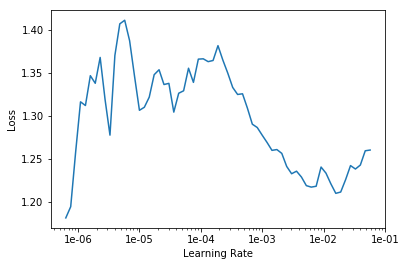

In [19]:
# iteration 1
exp = get_baseline_exp1('exp1_bs64_224_efficientnet-b2', efficient_net('b2'), bs=64)
exp.find_lr()

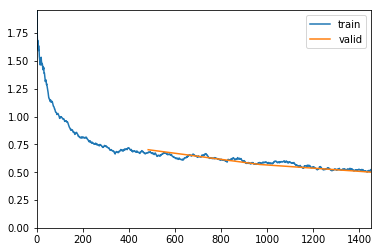

Better model found at epoch 0 with valid_loss value: 0.7020165920257568.
Better model found at epoch 1 with valid_loss value: 0.5692717432975769.
Better model found at epoch 2 with valid_loss value: 0.500103235244751.


In [16]:
exp.fit_frozen(3, 1e-4)

Loaded pretrained weights for efficientnet-b2
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


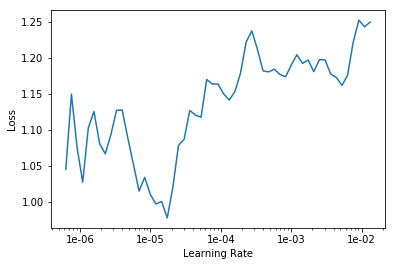

In [23]:
# iteration 2
exp = get_baseline_exp1('exp1_bs16_224_efficientnet-b2', efficient_net('b2'), bs=16)
exp.find_lr()

/home/adeperio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


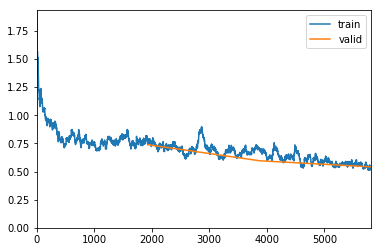

Better model found at epoch 0 with valid_loss value: 0.7379746437072754.
Better model found at epoch 1 with valid_loss value: 0.5954458117485046.
Better model found at epoch 2 with valid_loss value: 0.541480541229248.


In [24]:
exp.fit_frozen(3, 1e-3)

Loaded pretrained weights for efficientnet-b5
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


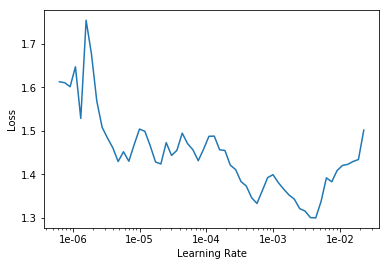

In [13]:
exp = get_baseline_exp1('exp1_bs16_224_efficientnet-b5', efficient_net('b5'), bs=16)
exp.find_lr()

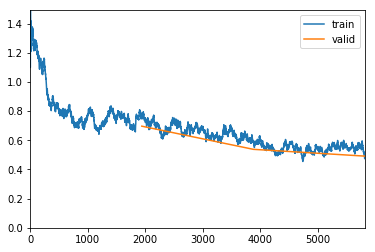

Better model found at epoch 0 with valid_loss value: 0.69666588306427.
Better model found at epoch 1 with valid_loss value: 0.5378988981246948.
Better model found at epoch 2 with valid_loss value: 0.49134281277656555.


<IPython.core.display.Javascript object>

In [14]:
exp.fit_frozen(3, 5e-4)

## (Exp-2) Progressive Resize

#### Summary

We pretrained 224px on 2015 and 2019 data.

Then we used this to progressize resize to 352, and only on the 2019 data.

This resulted in a significant boost to our CV score.

In [9]:
# Our baseline hyperparameters
def get_baseline_exp2(name, arch, data_source, bs, sz, pretrained_model_name=None):
    
    return Experiment(
            name=name, 
            data_source=data_source, 
            arch=arch, 
            image_size=sz, 
            bs=bs, 
            wd=1e-2,
            use_xtra_tfms=True, 
            oversample=False, 
            pretrained_model_name=pretrained_model_name)

#### start with 224px

Loaded pretrained weights for efficientnet-b5
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


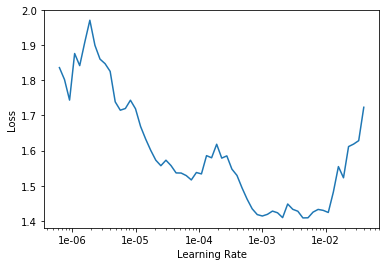

In [9]:
data_source = switch2019And2015(sub_folder = '224/')
exp = get_baseline_exp2('exp2_bs16_224_efficientnet-b5', data_source, efficient_net('b5'), bs=16, sz=224)
exp.find_lr()

In [ ]:
exp.fit_frozen(3, 7e-4)

#### transfer learn up to 352, 2019 Only

Loaded pretrained weights for efficientnet-b5
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/352/
Using get_transforms
Loading pretrained model: exp2_bs16_224_efficientnet-b5


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


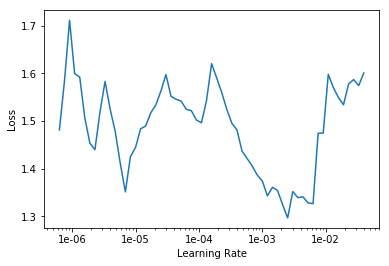

In [10]:
exp = get_baseline_exp2('exp2_bs16_352_efficientnet-b5', 
                        efficient_net('b5'), 
                        switch2019Only(sub_folder = '352/'),
                        bs=8, 
                        sz=352,
                        pretrained_model_name='exp2_bs16_224_efficientnet-b5')
exp.find_lr()

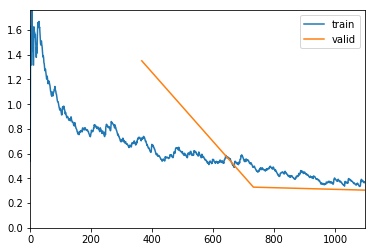

Better model found at epoch 0 with valid_loss value: 1.3506337404251099.
Better model found at epoch 1 with valid_loss value: 0.32884085178375244.
Better model found at epoch 2 with valid_loss value: 0.3046622574329376.


<IPython.core.display.Javascript object>

In [11]:
exp.fit_frozen(3, 5e-4)

## (Exp-3) Oversample vs Non-Oversample

#### Summary

As we can clearly see, although there was an imbalance with the dataset, oversampling gave significantly poorer results.

We turn Oversampling off on our main training run.


In [10]:
# Our baseline hyperparameters
def get_baseline_exp3(name, oversample):
    
    return Experiment(
            name=name, 
            data_source=switch2019And2015(sub_folder = '224/'), 
            arch=efficient_net('b2'), 
            image_size=224, 
            bs=64, 
            wd=1e-2,
            use_xtra_tfms=True, 
            oversample=oversample, 
            pretrained_model_name=None)

### Oversample

Loaded pretrained weights for efficientnet-b2
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms
is oversampling


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.51E-04
Min loss divided by 10: 2.00E-03


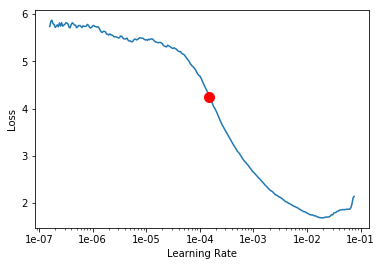

In [11]:
exp = get_baseline_exp3('exp3_bs64_224_efficientnet-b2', True)
exp.find_lr()

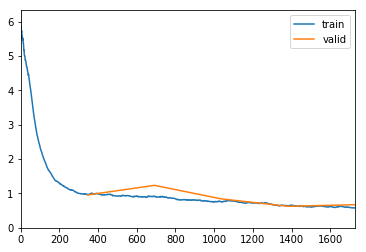

Better model found at epoch 0 with valid_loss value: 0.9569430351257324.
Better model found at epoch 2 with valid_loss value: 0.8411678671836853.
Better model found at epoch 3 with valid_loss value: 0.6268053650856018.


<IPython.core.display.Javascript object>

Saved model: /hdd/data/blindness-detection/2015_and_2019/exp3_bs64_224_efficientnet-b2


In [12]:
exp.fit_frozen(5, 1e-3)

### Non-Oversample

Loaded pretrained weights for efficientnet-b2
Using data in: /hdd/data/blindness-detection/2015_and_2019/train/224/
Using get_transforms


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-07
Min loss divided by 10: 6.92E-04


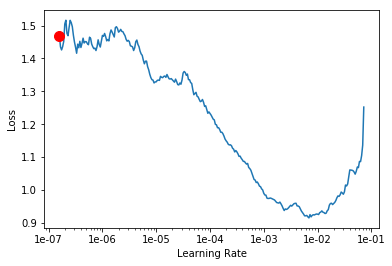

In [13]:
exp = get_baseline_exp3('exp3_bs64_224_efficientnet-b2', False)
exp.find_lr()

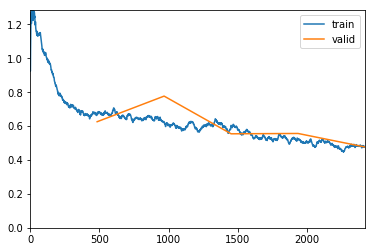

Better model found at epoch 0 with valid_loss value: 0.6258118152618408.
Better model found at epoch 2 with valid_loss value: 0.5545154213905334.
Better model found at epoch 4 with valid_loss value: 0.47669753432273865.


<IPython.core.display.Javascript object>

Saved model: /hdd/data/blindness-detection/2015_and_2019/exp3_bs64_224_efficientnet-b2


In [14]:
exp.fit_frozen(5, 1e-3)

---

# References

Fastai starter code
- https://www.kaggle.com/demonplus/fast-ai-starter-with-resnet-50/notebook

Google work on diabetic retiopathy:
- https://ai.googleblog.com/2018/12/improving-effectiveness-of-diabetic.html
- https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html

Image processing:
- bens original - https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping
- circle cropping https://www.kaggle.com/taindow/pre-processing-train-and-test-images
- Paper on focusing on green channel for most information http://biomedpharmajournal.org/vol10no2/diabetic-retinal-fundus-images-preprocessing-and-feature-extraction-for-early-detection-of-diabetic-retinopathy/
- Green channel post on discussion board - https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/102613#latest-598093

Pretrained Models (Cadene):
- https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb
- https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs_more.ipynb

Previous competition data:
- https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images


